In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: Healthcare Providers.csv  


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

# Anomaly Detection Libraries
from pyod.models.iforest import IForest  # Isolation Forest
from pyod.models.lof import LOF          # Local Outlier Factor

# Deep Learning (Autoencoder) Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Set Seaborn style
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [16]:
# 1. Load Data
try:
    df = pd.read_csv('healthcare.csv')
except FileNotFoundError:
    print("healthcare.csv not found. Generating sample data...")
    # Create mock data if file is missing (adjust weights for imbalance)
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=5000, n_features=20, n_informative=10,
                               n_redundant=5, n_classes=2, weights=[0.97, 0.03],
                               flip_y=0, random_state=42)
    df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(20)])
    df['FRAUD'] = y # Assuming target column name

print(df.head())
print("\n--- Data Info ---")
df.info()

healthcare.csv not found. Generating sample data...
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.089219   3.538334   1.315531  -2.456809   0.860346  -3.369643   
1   1.500975   0.797164   2.255629  -0.374197  -1.389942   0.194732   
2   0.031882  -0.667558   5.940603  -1.186330  -4.481134  -4.261102   
3  -0.372029  -2.002243  -1.268879   3.276632   5.633397  -0.787716   
4  -5.275855  -8.150316   2.476049  -5.157378  -1.054716   5.599960   

   feature_6  feature_7  feature_8  feature_9  ...  feature_11  feature_12  \
0   1.815543  -0.991922  -1.610646  -0.694978  ...    1.107148   -0.580324   
1   0.772954  -0.793745  -1.731240  -0.511148  ...   -0.812607   -1.212570   
2   5.256514  -0.150031  -0.808080   7.771690  ...    1.540736    0.623782   
3  -3.212555  -3.299282  -1.059231  -8.325544  ...   -2.318142    1.286402   
4   3.671861   3.606122  -3.615210   3.264036  ...   -0.239995    0.578895   

   feature_13  feature_14  feature_15  feature_16  f

In [17]:
# We assume 0: Normal, 1: Fraud.
TARGET_COLUMN = 'FRAUD'

if TARGET_COLUMN not in df.columns:
    print(f"Warning: '{TARGET_COLUMN}' column not found. Assuming the last column is the target.")
    TARGET_COLUMN = df.columns[-1]

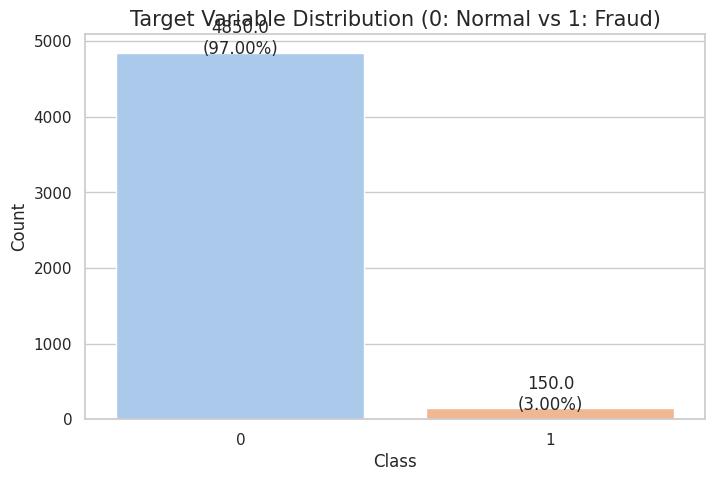

In [18]:
# 3. Target Variable Distribution (Checking Imbalance)
plt.figure(figsize=(8, 5))
total_len = len(df)
ax = sns.countplot(x=TARGET_COLUMN, data=df, palette='pastel')
plt.title('Target Variable Distribution (0: Normal vs 1: Fraud)', fontsize=15)
plt.xlabel('Class')
plt.ylabel('Count')
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total_len:.2f}%'
    count = p.get_height()
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}\n({percentage})', (x, y), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

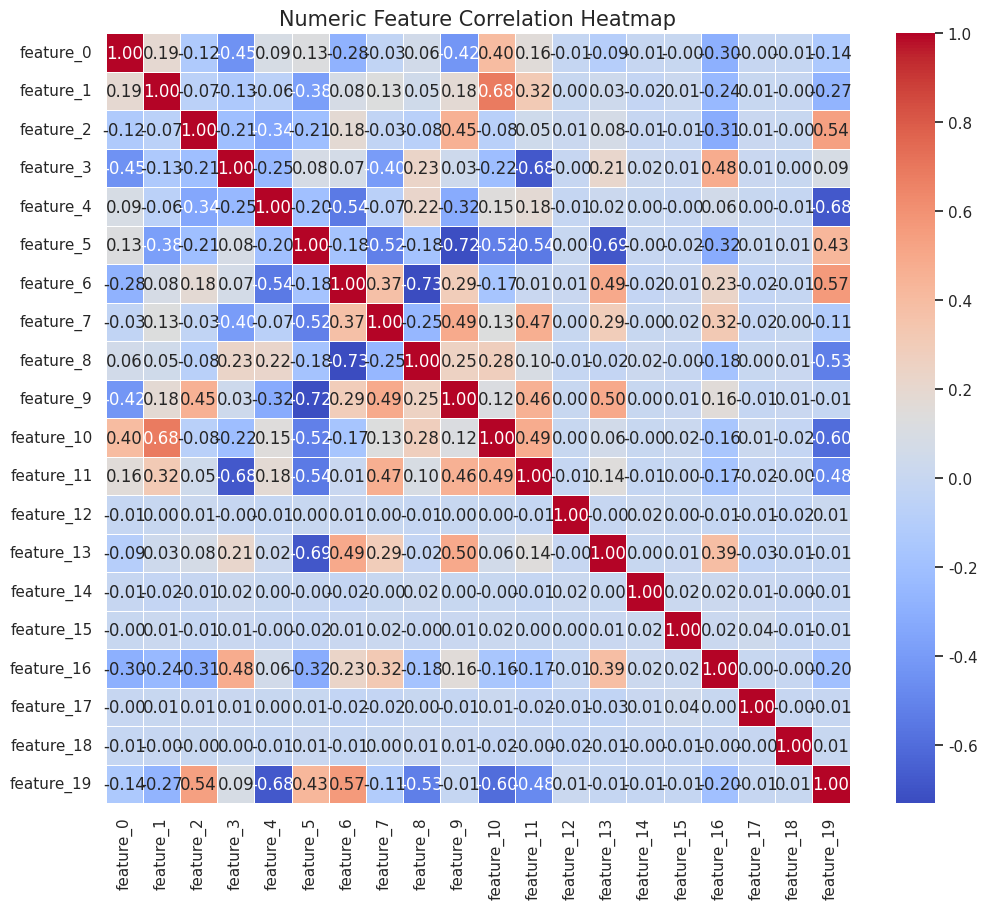

In [19]:
# 4. Numeric Feature Correlation Heatmap
numeric_cols = df.select_dtypes(include=np.number).columns
if TARGET_COLUMN in numeric_cols:
    numeric_cols = numeric_cols.drop(TARGET_COLUMN)

plt.figure(figsize=(12, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Numeric Feature Correlation Heatmap', fontsize=15)
plt.show()

In [20]:
# 2. Separate Features (X) and Target (y)
y = df[TARGET_COLUMN]
X = df.drop(TARGET_COLUMN, axis=1)

# 3. Standard Scaling
# Scaling is essential for distance-based models (LOF) and neural networks (Autoencoder).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train / Test Split
# (CRITICAL) We must use stratify=y to ensure the imbalance ratio is preserved in both sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Fraud ratio in test labels: {y_test.value_counts(normalize=True)[1]:.4f}")

# 5. Define Contamination Rate
# We set the 'contamination' parameter for the models based on the real fraud ratio in our data.
contamination_rate = y.value_counts(normalize=True)[1]
print(f"\nDataset Contamination (Fraud Rate): {contamination_rate:.4f}")

Training data shape: (3500, 20)
Test data shape: (1500, 20)
Fraud ratio in test labels: 0.0300

Dataset Contamination (Fraud Rate): 0.0300


In [21]:
models = {} # Dictionary to store results
model_metrics = [] # List to store performance metrics for comparison

# --- Model 1: Isolation Forest (Original) ---
print("\n[Model 1] Training Isolation Forest...")
clf_if = IForest(contamination=contamination_rate, random_state=42)
clf_if.fit(X_train)
y_pred_if = clf_if.predict(X_test)
models['Isolation Forest'] = y_pred_if

# --- Model 2: Local Outlier Factor (LOF) (Original) ---
print("[Model 2] Training Local Outlier Factor (LOF)...")
clf_lof = LOF(contamination=contamination_rate)
clf_lof.fit(X_train) # Note: LOF 'fit' is lazy; computation happens at prediction.
y_pred_lof = clf_lof.predict(X_test)
models['LOF'] = y_pred_lof

# --- Model 3: Autoencoder (Deep Learning) (Added) ---
print("[Model 3] Training Autoencoder...")
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2) # Hyperparameter for encoded dimension

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = Dense(int(encoding_dim / 2), activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder) # Reconstruct original
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# (CRITICAL) Autoencoders for anomaly detection must be trained ONLY on NORMAL data.
# This teaches the model the pattern of "normal," so it fails to reconstruct "abnormal" (fraud).
X_train_normal = X_train[y_train == 0]

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0)

history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=100,
                          batch_size=64,
                          shuffle=True,
                          validation_split=0.1, # Use 10% of normal training data for validation
                          callbacks=[early_stop],
                          verbose=0) # Suppress training logs

# Calculate reconstruction error on the full Test set (which includes fraud)
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Set the threshold based on the known contamination rate
# The error value at the (100 - (contamination_rate*100)) percentile is our threshold
threshold = np.percentile(mse, 100 * (1 - contamination_rate))

# If reconstruction error > threshold, classify as fraud (1), else normal (0)
y_pred_ae = (mse > threshold).astype(int)
models['Autoencoder'] = y_pred_ae

print("All models trained and predictions complete.")


[Model 1] Training Isolation Forest...
[Model 2] Training Local Outlier Factor (LOF)...
[Model 3] Training Autoencoder...
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
All models trained and predictions complete.


In [22]:
# --- Helper function for evaluation plots (All titles/labels in ENGLISH) ---
def plot_evaluation_metrics(y_true, y_pred, model_name):
    """
    Plots a Confusion Matrix and prints a Classification Report.
    Returns key metrics for the positive (Fraud) class.
    """
    cm = confusion_matrix(y_true, y_pred)

    # Generate report dictionary
    report_dict = classification_report(y_true, y_pred, target_names=['Normal (0)', 'Fraud (1)'], output_dict=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal (0)', 'Fraud (1)'],
                yticklabels=['Normal (0)', 'Fraud (1)'])
    plt.title(f'[{model_name}] Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\n--- [{model_name}] Classification Report ---")
    print(f"Overall Accuracy: {report_dict['accuracy']:.4f}\n")

    print("--- Performance for FRAUD (Class 1) ---")
    precision = report_dict['Fraud (1)']['precision']
    recall = report_dict['Fraud (1)']['recall']
    f1 = report_dict['Fraud (1)']['f1-score']

    print(f"Precision: {precision:.4f}")
    print(f"  (Of all alerts flagged, {precision*100:.2f}% were actual fraud)")
    print(f"Recall:    {recall:.4f}")
    print(f"  (The model caught {recall*100:.2f}% of all actual fraud cases)")
    print(f"F1-Score:  {f1:.4f} (Harmonic mean of Precision and Recall)")
    print("-"*(len(model_name)+30))

    # Return metrics for comparison summary
    return {
        'Model': model_name,
        'Accuracy': report_dict['accuracy'],
        'Fraud_Precision': precision,
        'Fraud_Recall': recall,
        'Fraud_F1_Score': f1
    }

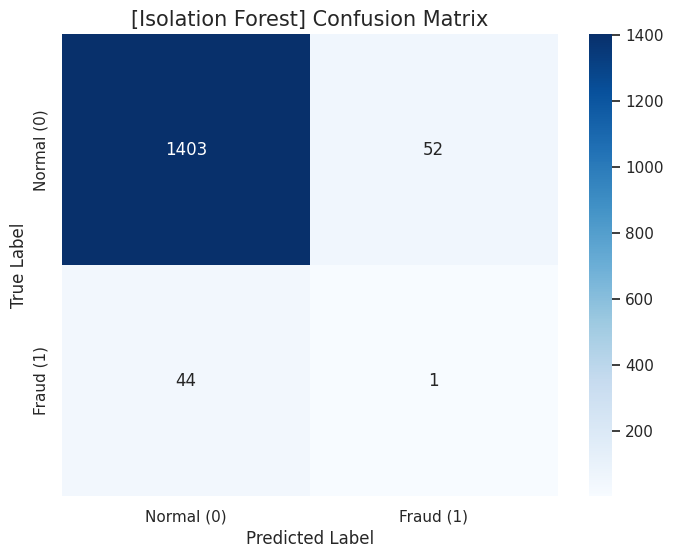


--- [Isolation Forest] Classification Report ---
Overall Accuracy: 0.9360

--- Performance for FRAUD (Class 1) ---
Precision: 0.0189
  (Of all alerts flagged, 1.89% were actual fraud)
Recall:    0.0222
  (The model caught 2.22% of all actual fraud cases)
F1-Score:  0.0204 (Harmonic mean of Precision and Recall)
----------------------------------------------


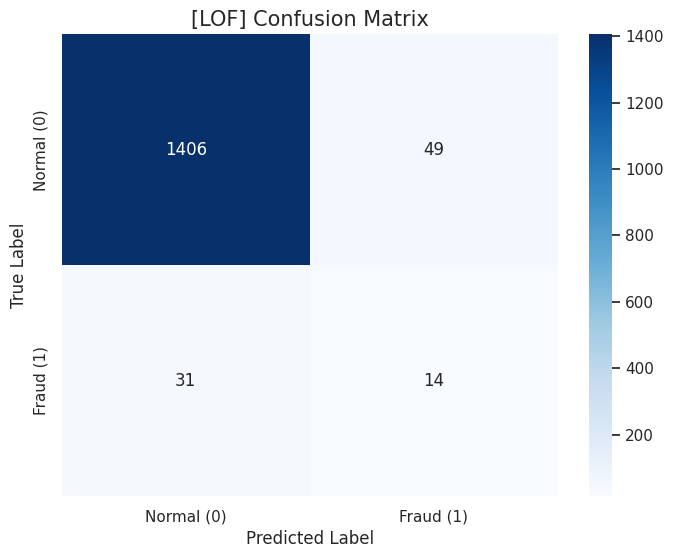


--- [LOF] Classification Report ---
Overall Accuracy: 0.9467

--- Performance for FRAUD (Class 1) ---
Precision: 0.2222
  (Of all alerts flagged, 22.22% were actual fraud)
Recall:    0.3111
  (The model caught 31.11% of all actual fraud cases)
F1-Score:  0.2593 (Harmonic mean of Precision and Recall)
---------------------------------


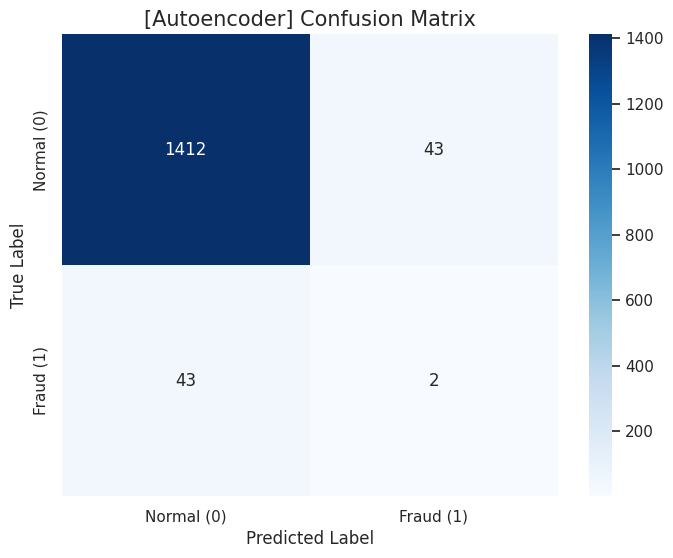


--- [Autoencoder] Classification Report ---
Overall Accuracy: 0.9427

--- Performance for FRAUD (Class 1) ---
Precision: 0.0444
  (Of all alerts flagged, 4.44% were actual fraud)
Recall:    0.0444
  (The model caught 4.44% of all actual fraud cases)
F1-Score:  0.0444 (Harmonic mean of Precision and Recall)
-----------------------------------------


In [23]:
# --- Run evaluation for all models ---
for model_name, y_pred in models.items():
    metrics = plot_evaluation_metrics(y_test, y_pred, model_name)
    model_metrics.append(metrics)

In [24]:
# --- Final Metrics Comparison ---
metrics_df = pd.DataFrame(model_metrics).set_index('Model')
print("\n\n--- [Overall Model Comparison Summary] ---")
print(metrics_df.to_markdown(floatfmt=".4f"))



--- [Overall Model Comparison Summary] ---
| Model            |   Accuracy |   Fraud_Precision |   Fraud_Recall |   Fraud_F1_Score |
|:-----------------|-----------:|------------------:|---------------:|-----------------:|
| Isolation Forest |     0.9360 |            0.0189 |         0.0222 |           0.0204 |
| LOF              |     0.9467 |            0.2222 |         0.3111 |           0.2593 |
| Autoencoder      |     0.9427 |            0.0444 |         0.0444 |           0.0444 |


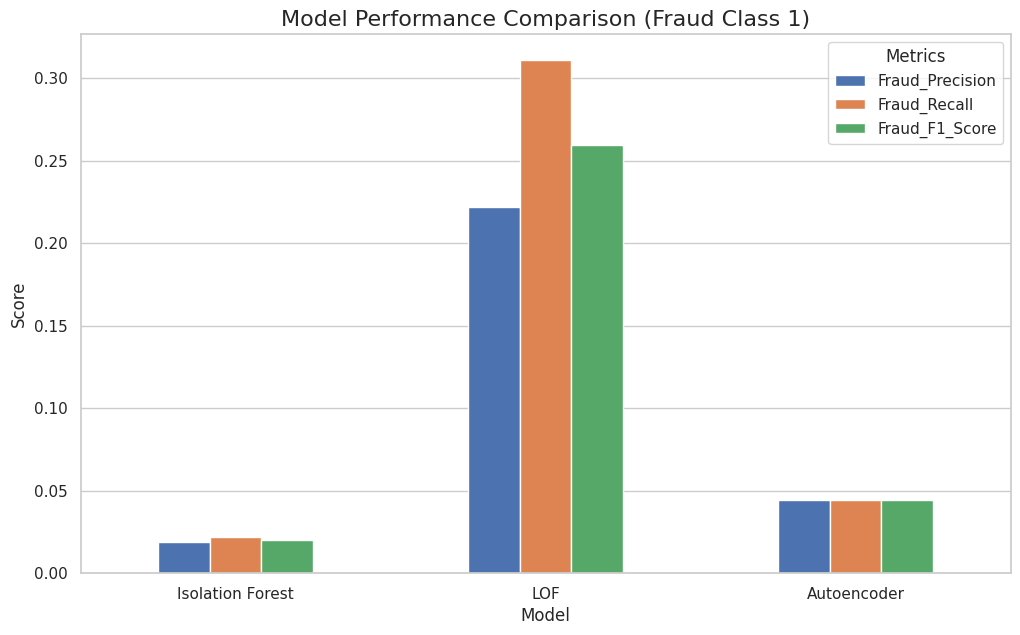

In [25]:
# Plot comparison chart (Focusing on F1 and Recall for Fraud)
metrics_df[['Fraud_Precision', 'Fraud_Recall', 'Fraud_F1_Score']].plot(
    kind='bar',
    figsize=(12, 7),
    rot=0
)
plt.title('Model Performance Comparison (Fraud Class 1)', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metrics')
plt.grid(axis='x')
plt.show()

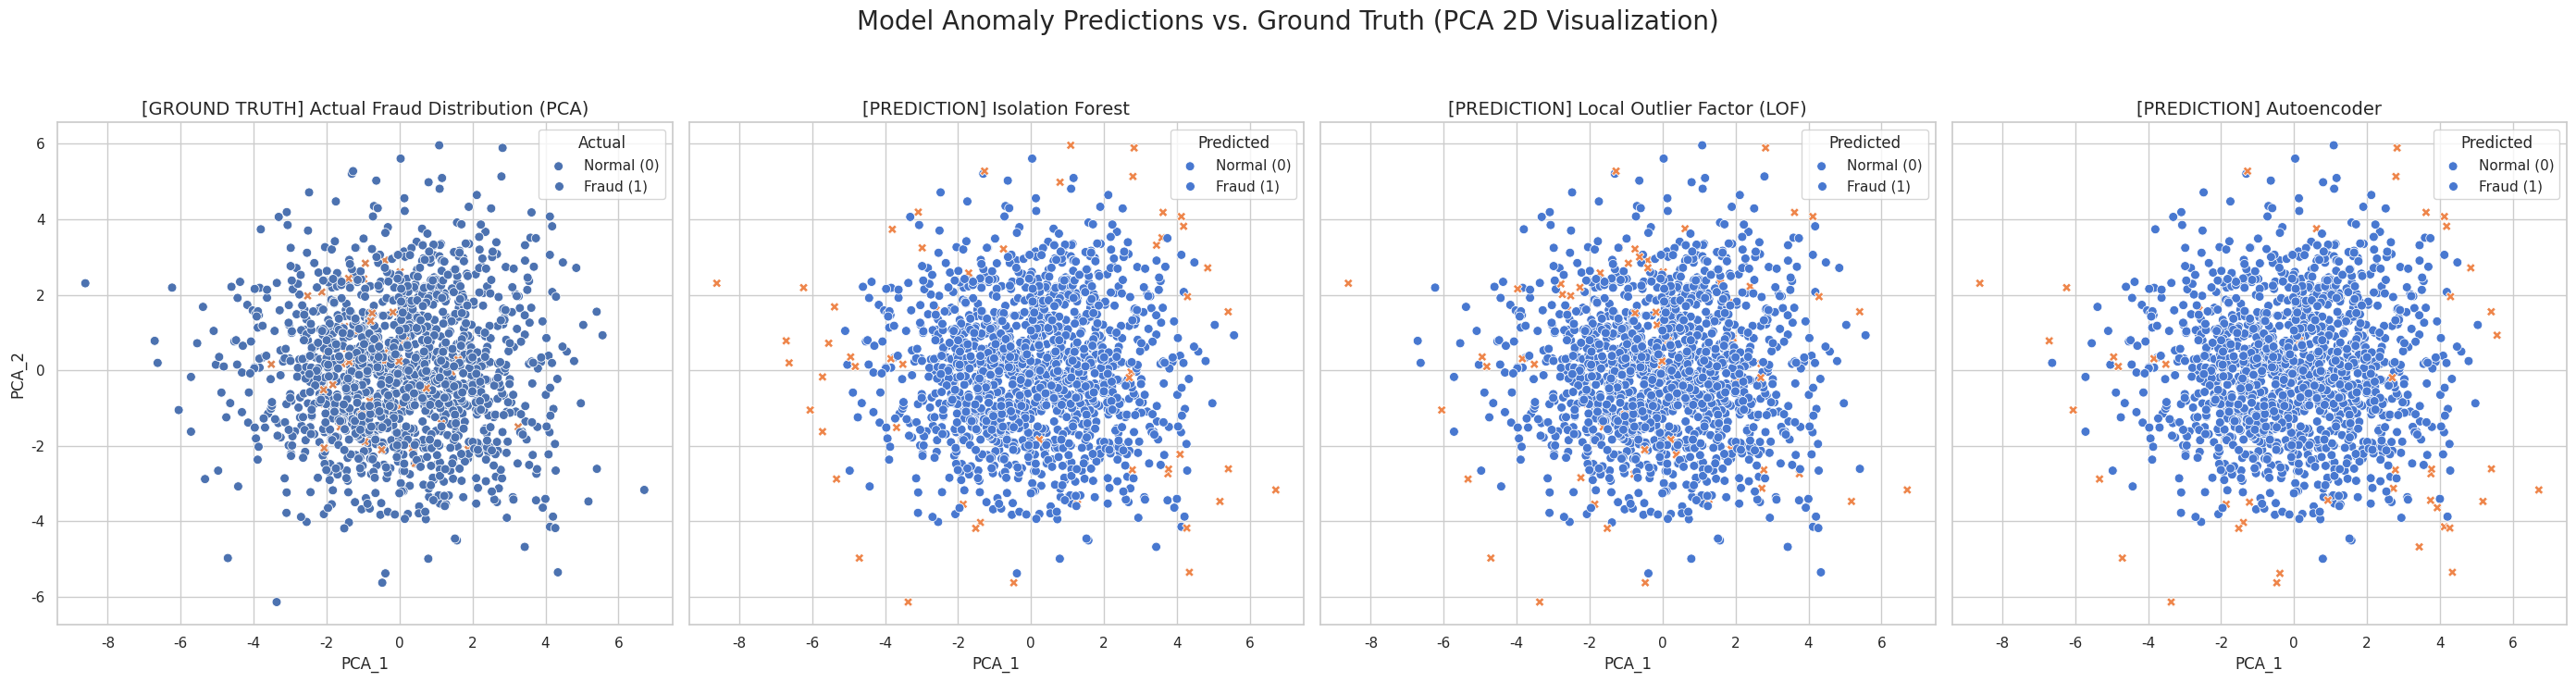

In [29]:
# 1. Apply PCA (reducing to 2 components)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# 2. Create DataFrame for plotting
df_pca = pd.DataFrame(data=X_test_pca, columns=['PCA_1', 'PCA_2'])
# Add true labels and predictions from all models
df_pca['True_Label'] = y_test.values
df_pca['IF_Pred'] = models['Isolation Forest']
df_pca['LOF_Pred'] = models['LOF']
df_pca['AE_Pred'] = models['Autoencoder']

# 3. Create 4-Panel Comparison Plot
fig, axes = plt.subplots(1, 4, figsize=(28, 7), sharex=True, sharey=True)

# Plot 1: Ground Truth (The actual answer)
sns.scatterplot(data=df_pca, x='PCA_1', y='PCA_2', hue='True_Label',
                style='True_Label', ax=axes[0], palette='deep', s=50, legend='full')
axes[0].set_title('[GROUND TRUTH] Actual Fraud Distribution (PCA)', fontsize=14)
axes[0].legend(title='Actual', labels=['Normal (0)', 'Fraud (1)'])

# Plot 2: Isolation Forest Predictions
sns.scatterplot(data=df_pca, x='PCA_1', y='PCA_2', hue='IF_Pred',
                style='IF_Pred', ax=axes[1], palette='muted', s=50, legend='full')
axes[1].set_title('[PREDICTION] Isolation Forest', fontsize=14)
axes[1].legend(title='Predicted', labels=['Normal (0)', 'Fraud (1)'])

# Plot 3: LOF Predictions
sns.scatterplot(data=df_pca, x='PCA_1', y='PCA_2', hue='LOF_Pred',
                style='LOF_Pred', ax=axes[2], palette='muted', s=50, legend='full')
axes[2].set_title('[PREDICTION] Local Outlier Factor (LOF)', fontsize=14)
axes[2].legend(title='Predicted', labels=['Normal (0)', 'Fraud (1)'])

# Plot 4: Autoencoder Predictions
sns.scatterplot(data=df_pca, x='PCA_1', y='PCA_2', hue='AE_Pred',
                style='AE_Pred', ax=axes[3], palette='muted', s=50, legend='full')
axes[3].set_title('[PREDICTION] Autoencoder', fontsize=14)
axes[3].legend(title='Predicted', labels=['Normal (0)', 'Fraud (1)'])

plt.suptitle("Model Anomaly Predictions vs. Ground Truth (PCA 2D Visualization)", fontsize=20, y=1.05)
plt.tight_layout()
plt.show()